# ML for price modeling



In [1]:
### Import packages

import os
import boto3
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
from haversine import haversine

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.impute import SimpleImputer

from sklearn.inspection import partial_dependence

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Constants

CONFIG = {'title': 18,
          'subtitle': 16,
          'label': 14,
          'tick': 12,
          'legend': 14}
RANDOM_SEED = 888
MODEL_PATH = './production/'

In [3]:
### Database credentials

DB_HOST = os.environ.get('DB_HOST')
DB_PORT = os.environ.get('DB_PORT')
DB_NAME = os.environ.get('DB_NAME')
DB_USERNAME = os.environ.get('DB_USERNAME')
DB_PASSWORD = os.environ.get('DB_PASSWORD')

DB_URL = f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

In [4]:
### Define functions

def plot_formatting(ax, parameters, config = CONFIG, ignore_ticks = False, has_legend = False):
    
    # Set labels
    ax.set_xlabel(parameters['x_label'], fontsize = config['label'])
    ax.set_ylabel(parameters['y_label'], fontsize = config['label'])
    
    # Set title
    if('title' in parameters.keys()):
        ax.set_title(parameters['title'], fontsize = config['title'])
        
    # Set subtitle
    if('subtitle' in parameters.keys()):
        ax.set_title(parameters['subtitle'], fontsize = config['subtitle'])
    
    # Set tick size
    if(not ignore_ticks):
        ax.tick_params(axis = 'both', which = 'major', labelsize = config['tick'])
    
    # Set legend
    if(has_legend):
        ax.legend(loc = 'best', fontsize = config['legend'])
        
# Create split of bathroom
def parse_bathrooms(df):

    # Row check
    ORIGINAL_ROWS = df.shape[0]
    
    # Infer number bathrooms
    df['bathroom_number'] = df['bathrooms_text'].str.split(' ', expand = True)[0]
    df['bathroom_number'] = pd.to_numeric(df['bathroom_number'], errors = 'coerce')

    # Add half bathrooms in text
    df.loc[(df['bathrooms_text'].str.contains('half')) & (df['bathroom_number'].isnull()),
           'bathroom_number'] = 0.5

    # Extract private or shared. Default is private
    df['bathroom_type'] = 'private'
    df.loc[df['bathrooms_text'].str.contains('shar', na = False),
           'bathroom_type'] = 'shared'
    df.loc[df['bathrooms_text'].isnull(), 'bathroom_type'] = None

    df.drop(columns = ['bathrooms_text'], inplace = True)

    FINAL_ROWS = df.shape[0]
    if(FINAL_ROWS == ORIGINAL_ROWS):
        return df
    else:
        raise Exception('Oh oh, the process removed rows!')
        
# Retrieve numerical columns after applying pipeline
def retrieve_pipeline_names_numeric(pipelineObject):
    feats = [i for i in pipelineObject[2]]
    return feats;

# Retrieve categorical columns after applying pipeline
def retrieve_pipeline_names_categorical(pipelineObject, encoder_index):
    feats = [i for i in pipelineObject[2]]
    
    CAT_PREFIX = [i + '_' for i in pipelineObject[2]]
    CAT_LIST = [i for i in pipelineObject[1][encoder_index].categories_]
    CAT_LIST_DROP_INDEX = [i for i in pipelineObject[1][encoder_index].drop_idx_]
    CAT_LIST = [np.delete(l, CAT_LIST_DROP_INDEX[i]) for i, l in enumerate(CAT_LIST)]
    CAT_PREFIX_LIST = [np.repeat(CAT_PREFIX[i], len(element)) for i, element in enumerate(CAT_LIST)]
    CAT_LIST_FINAL = [j for i in CAT_LIST for j in i]
    CAT_PREFIX_LIST = [j for i in CAT_PREFIX_LIST for j in i]
    CAT_LIST_FINAL = [CAT_PREFIX_LIST[i] + CAT_LIST_FINAL[i] for i in range(len(CAT_PREFIX_LIST))]
    
    return CAT_LIST_FINAL;

# Function to plot feature importance
def plot_feature_importance(ax, dict_features):

    # Define colours
    colour = {'yes': '#e3963e',
         'no': '#6691c1'}
    
    # Process data    
    df_feature_importance = pd.DataFrame(dict_features)
    df_feature_importance.sort_values(by = 'importance', ascending = False, inplace = True)
    df_feature_importance.reset_index(drop = True, inplace = True)

    df_feature_importance['top'] = np.where(df_feature_importance.index < 5, 'yes', 'no')
    feature_importance_top = df_feature_importance['importance'][df_feature_importance['top'] == 'yes'].sum()

    # Plot results
    ax.barh(df_feature_importance['feature'].head(10),
           df_feature_importance['importance'].head(10),
           color = df_feature_importance['top'].head(10).map(colour))

    # Add text
    ax.text(0.175, # x-coordinate
            6, # y-coordinate
            '{:.1%}'.format(feature_importance_top), # Label (text) to display
            color = '#9e692b',
            fontsize = 40,
            ha = 'center',
            va = 'center') # Alignment of the text

    ax.text(0.175, # x-coordinate
            6.8, # y-coordinate
            'of importance captured in top 5 features', # Label (text) to display
            color = '#9e692b',
            fontsize = 15,
            ha = 'center',
            va = 'center') # Alignment of the text

    # Format plot
    ax.invert_yaxis()

    ax.tick_params(axis = 'both', which = 'major', labelsize = 12,
                   top = True, labeltop = True,
                   bottom = False, labelbottom = False)
    
    return ax;

# Ccalculates and plots the partial dependence of a given variable in a predictive model
def plot_partial_dependence(df_X, sr_y, feature, model, pipeline, ax, cat_number = 10):

    # Identify position of feature in df
    pos_feature_df = df_X.columns.tolist().index(feature)

    # Extract pipeline and position within transformer
    for element in pipeline.transformers_:
        if(feature in element[2]):
            internal_pipeline = element
            break

    pos_feature_pipeline = internal_pipeline[2].index(feature)
    pipeline_features_len = len(internal_pipeline[2])

    # Extract transformers
    pipeline_steps = [i for i in internal_pipeline[1][1:]]
    pipeline_steps.reverse()

    # Compute partial dependence
    pd_tuple = partial_dependence(model, df_X, features = [feature])
    pd_y = pd_tuple[0][0]
    pd_X = np.zeros((len(pd_y), pipeline_features_len))
    pd_X[:, pos_feature_pipeline] = pd_tuple[1][0]
    
    for step in pipeline_steps:
        pd_X = step.inverse_transform(pd_X)
        
    pd_X_reverse = pd_X[:, pos_feature_pipeline]

    # Create bins of real data
    X_scaled = np.zeros((len(df_X), pipeline_features_len))
    X_scaled[:, pos_feature_pipeline] = df_X[feature].tolist()
    
    for step in pipeline_steps:
        X_scaled = step.inverse_transform(X_scaled)
    
    X_descaled = X_scaled[:, pos_feature_pipeline]

    df_real = pd.DataFrame(data = {feature: X_descaled, 'target': sr_y})
    df_real['q'] = pd.qcut(df_real[feature], cat_number, duplicates = 'drop')

    df_real_grouped = df_real.groupby('q', as_index = False).mean()

    # References
    avg_real = sr_y.mean()
    x_reference = np.linspace(min(pd_X_reverse), max(pd_X_reverse), cat_number)
    y_reference = np.ones(len(x_reference)) * avg_real

    # Plot results
    ax.plot(pd_X_reverse,
          pd_y,
          label = 'Predicted',
          color = '#1261a0')

    # Add real plot
    ax.scatter(df_real_grouped[feature],
             df_real_grouped['target'],
             label = 'Actual',
             edgecolors = '#b20000',
             marker = 'o',
             s = 80,
             color = 'none')

    # Add references
    ax.plot(x_reference,
          y_reference,
          label = 'Average value',
          color = 'k',
          linestyle = '--')

    # Format axes
    ax.set(xlim = [x_reference.min(), x_reference.max()])

    fmt = '£{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    
    return ax;

## Getting the data

In [5]:
### Read data from database

try:

    df_dataset = pd.read_sql_table('base_training_data', DB_URL, schema = 'model')
    df_stations = pd.read_sql_table('tfl_stations', DB_URL, schema = 'city')
    df_postcodes = pd.read_sql_table('postcodes', DB_URL, schema = 'city')

    print('Table retrieved successfully.')
except:
    print('Oh oh, something happened mate. Try again.')

Table retrieved successfully.


## Transport score

In [6]:
### Define transport score

def transport_score(df_points, target_lat, target_lon, calibration):

    target_tuple = (target_lat, target_lon)
    latitude_list = df_points['latitude'].tolist()
    longitude_list = df_points['longitude'].tolist()

    source_tuples = [(i, j) for i, j in zip(latitude_list, longitude_list)]
    distance_list = [haversine(i, target_tuple) for i in source_tuples]
    df_points['distance'] = distance_list
    df_points['score_mark'] = df_points['distance'] <= calibration

    score = sum(df_points['score_mark']) / len(df_points['score_mark'])
    return score;

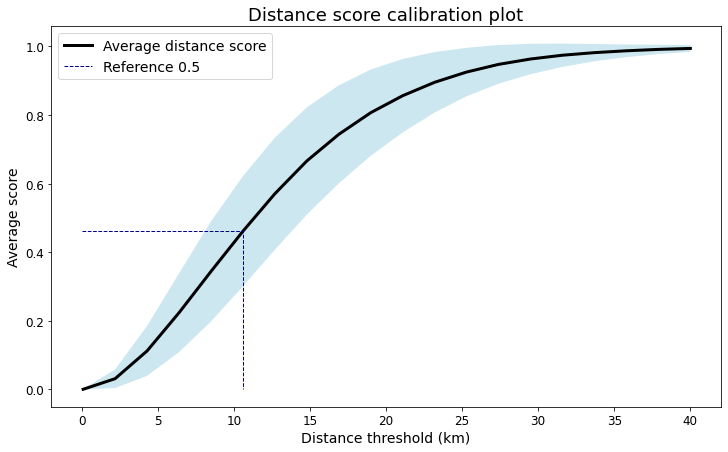

In [7]:
### Score distribution on distance calibration

df_coordinates = df_dataset.sample(1000, random_state = RANDOM_SEED).reset_index(drop = True)

listings_lat = df_coordinates['latitude']
listings_lon = df_coordinates['longitude']

# calibration_distance = np.linspace(0.1, 40, 200)
calibration_distance = np.linspace(0.1, 40, 20)
avg_score = []
std_score = []

for i in calibration_distance:
    SCORES = [transport_score(df_stations,
                             listings_lat[j],
                             listings_lon[j],
                             i) for j in range(len(listings_lat))]
    
    AVG_SCORE = np.mean(SCORES)
    STD_SCORE = np.std(SCORES)
    avg_score.append(AVG_SCORE)
    std_score.append(STD_SCORE)
   
# Build plot dataset
df_plot = pd.DataFrame({'cal_distance': calibration_distance,
                       'avg_score': avg_score,
                       'std_score': std_score})

df_plot['lower_shade'] = df_plot['avg_score'] - df_plot['std_score']
df_plot['upper_shade'] = df_plot['avg_score'] + df_plot['std_score']
df_plot['plot_reference'] = np.abs(df_plot['avg_score'] - 0.5)

index_min = df_plot['plot_reference'].idxmin()
reference_point = df_plot[['cal_distance', 'avg_score']].iloc[index_min].values

# Plot
fig = plt.figure(1, (12, 7))
ax = fig.add_subplot(1, 1, 1)

ax.plot(df_plot['cal_distance'],
       df_plot['avg_score'],
       color = 'k',
       linewidth = 3,
       label = 'Average distance score')

# Add shades
ax.fill_between(df_plot['cal_distance'],
                df_plot['lower_shade'],
                df_plot['upper_shade'],
                facecolor = '#add8e6', # The fill color
                alpha = 0.6)

# Set references
reference_x = [0, reference_point[0], reference_point[0]]
reference_y = [reference_point[1], reference_point[1], 0]

ax.plot(reference_x,
       reference_y,
       color = '#00008b',
       linewidth = 1,
       label = 'Reference 0.5',
       linestyle = '--')

# Format plot
plot_params = {'title': 'Distance score calibration plot',
             'x_label': 'Distance threshold (km)',
             'y_label': 'Average score'}

plot_formatting(ax, plot_params, has_legend = True)
    
plt.show()

In [8]:
### Merge station to dataframe

df_dataset_merged = df_dataset.copy()

listings_lat = df_dataset_merged['latitude']
listings_lon = df_dataset_merged['longitude']

score_stations = [transport_score(df_stations,
                                  listings_lat[j],
                                  listings_lon[j],
                                  10) for j in range(len(listings_lat))]

df_dataset_merged['score_stations'] = score_stations

## Initial visualisation, merging and set partition

In [9]:
### Dataset info

df_dataset_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66641 entries, 0 to 66640
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   listing_id            66641 non-null  int64         
 1   host_id               66641 non-null  int64         
 2   neighbourhood_id      66641 non-null  int64         
 3   latitude              66641 non-null  float64       
 4   longitude             66641 non-null  float64       
 5   property_type         66641 non-null  object        
 6   room_type             66641 non-null  object        
 7   accommodates          66641 non-null  int64         
 8   bathrooms_text        66397 non-null  object        
 9   bedrooms              62624 non-null  float64       
 10  beds                  62995 non-null  float64       
 11  price_per_night       65611 non-null  float64       
 12  minimum_nights        66641 non-null  int64         
 13  maximum_nights  

In [10]:
### Compute host seniority and neighbourhood zone

df_dataset_merged_processed = df_dataset_merged.copy()

df_dataset_merged_processed['date_reference'] = pd.to_datetime('2021-12-31')
df_dataset_merged_processed['seniority'] = (df_dataset_merged_processed['date_reference'] - df_dataset_merged_processed['host_since']) / pd.pandas.Timedelta(days=365)
df_dataset_merged_processed['seniority'] = np.round(pd.to_numeric(df_dataset_merged_processed['seniority']), 0)

# Merge zone
COLS_POSTCODES = ['neighbourhood_id', 'district', 'postcode_area']
df_postcodes_grouped = df_postcodes[COLS_POSTCODES].groupby(COLS_POSTCODES, as_index = False).size()
df_postcodes_grouped.sort_values(by = ['neighbourhood_id', 'size'], ascending = [True, False], inplace = True)
df_postcodes_grouped.reset_index(drop = True, inplace = True)
df_postcodes_grouped.drop_duplicates(subset = 'neighbourhood_id', keep = 'first', inplace = True)
df_postcodes_grouped.reset_index(drop = True, inplace = True)

df_dataset_merged_processed = pd.merge(df_dataset_merged_processed,
                                      df_postcodes_grouped[['neighbourhood_id', 'postcode_area']].rename(columns = {'postcode_area': 'zone'}),
                                      how = 'left',
                                      on = 'neighbourhood_id')

Average price per night: £116.71
Median price per night: £80.0



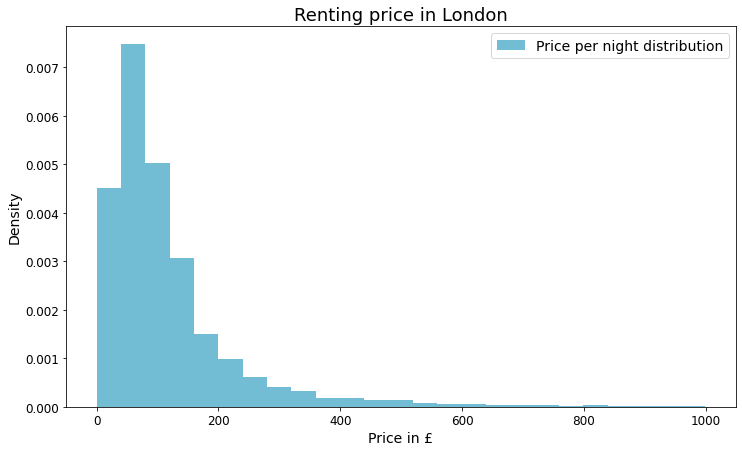

In [11]:
### Explore target - price

avg_price = np.round(df_dataset_merged_processed['price_per_night'].mean(), 2)
median_price = np.round(df_dataset_merged_processed['price_per_night'].median(), 2)

print(f'Average price per night: £{avg_price}')
print(f'Median price per night: £{median_price}\n')

# Plot price distribution
fig = plt.figure(1, (12, 7))
ax = fig.add_subplot(1, 1, 1)

ax.hist(df_dataset_merged_processed['price_per_night'],
       bins = 25,
       density = True,
       color = '#72bcd4',
       label = 'Price per night distribution')

# Format plot
plot_params = {'title': 'Renting price in London',
             'x_label': 'Price in £',
             'y_label': 'Density'}

plot_formatting(ax, plot_params, has_legend = True)

plt.show()

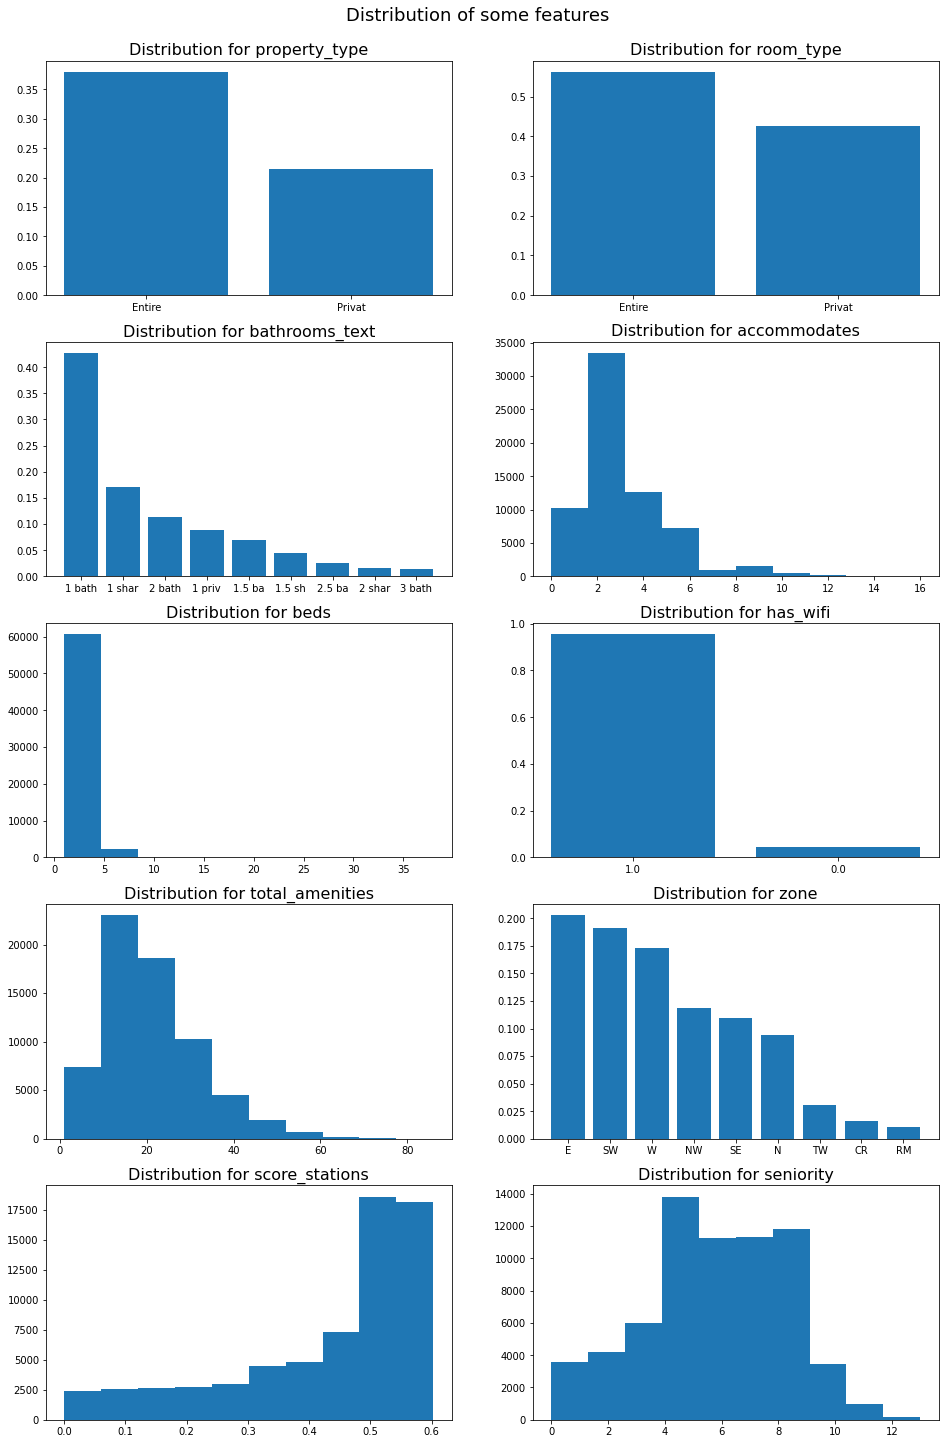

In [12]:
### Show some distribution examples

FEAT_TYPE = {'property_type': 'categorical',
            'room_type': 'categorical',
            'bathrooms_text': 'categorical',
            'accommodates': 'numeric',
             'beds': 'numeric',
            'has_wifi': 'categorical',
            'total_amenities': 'numeric',
            'zone': 'categorical',
            'score_stations': 'numeric',
            'seniority': 'numeric'}

# Plot distributions
fig, axs = plt.subplots(5, 2, figsize = (16, 25)) # Create figure and axes

for POS, FEATURE in enumerate(FEAT_TYPE):

    X_POS = POS // 2
    Y_POS = POS % 2

    if(FEAT_TYPE[FEATURE] == 'numeric'): # Histograms for numeric features

        axs[X_POS, Y_POS].hist(df_dataset_merged_processed[FEATURE])
            
    else:
        
        DIST = pd.DataFrame(df_dataset_merged_processed[FEATURE].value_counts(normalize = True)).reset_index()
        DIST = DIST[DIST[FEATURE] > 0.01]
        DIST['index'] = DIST['index'].apply(str)
        DIST['index'] = DIST['index'].str[:6]
        
        axs[X_POS, Y_POS].bar(DIST['index'],
                             DIST[FEATURE]) # Barplot for categorical features
        
#     axs[X_POS, Y_POS].set_xlabel(FEATURE, fontsize = FONT_SIZE['label']) # Set label of each feature
    axs[X_POS, Y_POS].set_title('Distribution for ' + FEATURE, fontsize = CONFIG['subtitle']) # Set subtitle of each feature
    
    
plt.suptitle('Distribution of some features',
             fontsize = CONFIG['title'],
             y = 0.91) # Main title of the plot
plt.show()

In [13]:
### Drop null values on target variable and partition sets

df_train, df_test = train_test_split(df_dataset_merged_processed,
                                     train_size = 0.8,
                                     random_state = RANDOM_SEED)

df_train.dropna(subset = ['price_per_night'], inplace = True)
df_test.dropna(subset = ['price_per_night'], inplace = True)

print('Size of training set: %s rows' % df_train.shape[0])
print('Size of test set: %s rows' % df_test.shape[0])

Size of training set: 52486 rows
Size of test set: 13125 rows


## Exploratory data analysis

In [14]:
### Distribution plots with categorical features

CAT_COLS = ['property_type', 'room_type', 'instant_bookable', 'response_time',
            'is_superhost', 'host_has_profile_pic', 'identity_verified', 'zone', 'has_wifi',
            'has_kitchen', 'has_heating', 'host_is_in_london', 'verification_phone',
            'verification_email', 'verification_gov_id', 'price_per_night']

df_train_eda_cat = df_train[CAT_COLS]

df_train_eda_cat.info()

print('\nNote that less than half values of response_time are not null')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52486 entries, 11860 to 10750
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_type         52486 non-null  object 
 1   room_type             52486 non-null  object 
 2   instant_bookable      52486 non-null  int64  
 3   response_time         25265 non-null  object 
 4   is_superhost          52443 non-null  float64
 5   host_has_profile_pic  52443 non-null  float64
 6   identity_verified     52443 non-null  float64
 7   zone                  52486 non-null  object 
 8   has_wifi              52449 non-null  float64
 9   has_kitchen           52449 non-null  float64
 10  has_heating           52449 non-null  float64
 11  host_is_in_london     52486 non-null  int64  
 12  verification_phone    52365 non-null  float64
 13  verification_email    52365 non-null  float64
 14  verification_gov_id   52365 non-null  float64
 15  price_per_night

We may group the less frequent zones into bigger ones, according to their location on the map.

There are 86 different property types, however it looks like room_type groups them correctly.



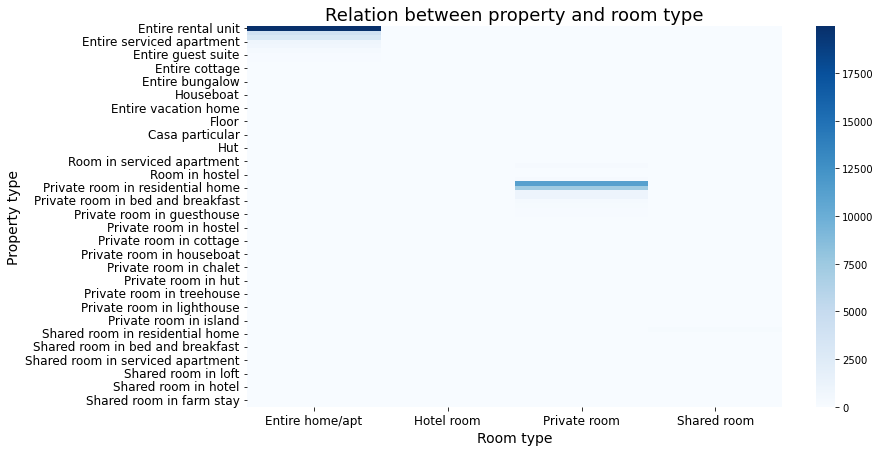

In [15]:
### Zone grouping
print('We may group the less frequent zones into bigger ones, according to their location on the map.\n')

ZONE_GROUP = {'E': 'E',
            'SW': 'SW',
            'W': 'W',
            'NW': 'NW',
            'SE': 'SE',
            'N': 'N',
            'TW': 'SW',
            'CR': 'SW',
            'RM': 'E',
            'IG': 'E',
            'UB': 'NW',
            'BR': 'SE',
            'KT': 'SW',
            'HA': 'NW',
            'EC': 'E',
            'SM': 'SW',
            'DA': 'SE'}

df_train_eda_cat['zone_group'] = df_train_eda_cat['zone'].map(ZONE_GROUP)

# Heatmap property type and room type
df_train_eda_cat_pt = pd.pivot_table(df_train_eda_cat,
                                     index = 'property_type',
                                     columns = 'room_type',
                                     aggfunc = 'size')

df_train_eda_cat_pt.fillna(0, inplace = True)

COLTS_PT = list(df_train_eda_cat_pt.columns.values)
df_train_eda_cat_pt.sort_values(by = COLTS_PT,
                               ascending = [False] * len(COLTS_PT),
                               inplace = True)

print('There are %s different property types, however it looks like room_type groups them correctly.\n' % df_train_eda_cat_pt.shape[0])

fig = plt.figure(1, (12, 7))
ax = fig.add_subplot(1, 1, 1)

CMAP = sns.color_palette('Blues', as_cmap=True)
ax = sns.heatmap(df_train_eda_cat_pt,
                cmap = CMAP,)

# Format plot
plot_params = {'title': 'Relation between property and room type',
             'x_label': 'Room type',
             'y_label': 'Property type'}

plot_formatting(ax, plot_params, has_legend = False)

plt.show()

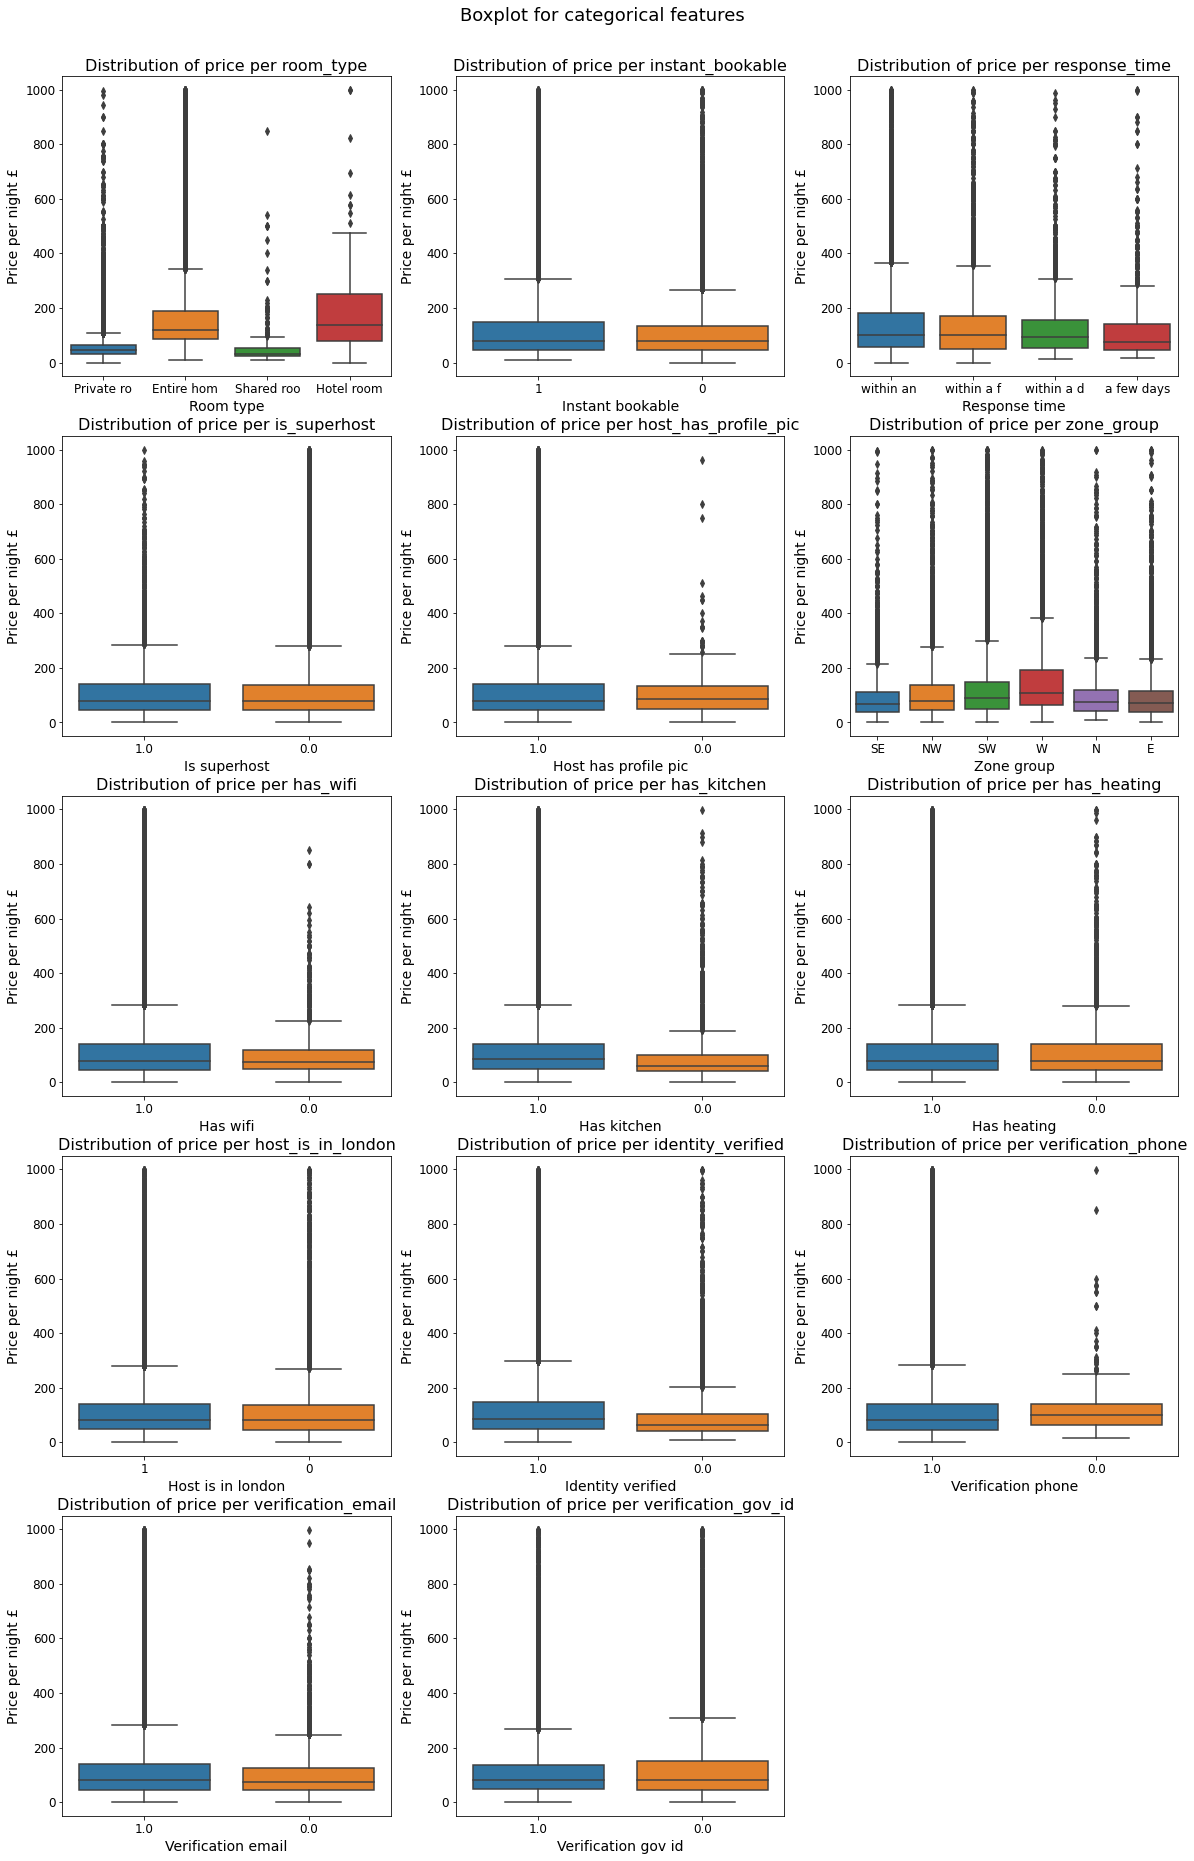

In [16]:
### Continue categorical EDA

COLS_BOXPLOT = ['room_type', 'instant_bookable', 'response_time', 'is_superhost',
                'host_has_profile_pic', 'zone_group', 'has_wifi',
                'has_kitchen', 'has_heating', 'host_is_in_london', 'identity_verified',
                'verification_phone', 'verification_email', 'verification_gov_id']

# Plot boxplots
fig, axs = plt.subplots(5, 3, figsize = (20, 32)) # Create figure and axes

for POS, FEATURE in enumerate(COLS_BOXPLOT):

    X_POS = POS // 3
    Y_POS = POS % 3
    
    # Separate data
    DF_PLOT = df_train_eda_cat[[FEATURE, 'price_per_night']]
    DF_PLOT.dropna(inplace = True)
    DF_PLOT[FEATURE] = DF_PLOT[FEATURE].apply(str)
    DF_PLOT[FEATURE] = DF_PLOT[FEATURE].str[:10] #Display only 10 characters to avoid clutter
    
    sns.boxplot(data = DF_PLOT,
                x = FEATURE,
                y = 'price_per_night',
                ax = axs[X_POS, Y_POS])
    
    # Format plot
    x_label = FEATURE.replace('_', ' ').capitalize()
    
    plot_params = {'subtitle': 'Distribution of price per ' + FEATURE,
                 'x_label': x_label,
                 'y_label': 'Price per night £'}

    plot_formatting(axs[X_POS, Y_POS], plot_params, has_legend = False)
        
axs[4, 2].remove()

plt.suptitle('Boxplot for categorical features',
             fontsize = CONFIG['title'],
             y = 0.91) # Main title of the plot
        
plt.show()

In [17]:
### Numerical values, data

NUM_COLS = ['accommodates', 'bedrooms', 'beds', 'minimum_nights',
            'maximum_nights', 'total_amenities', 'host_total_listings', 'verification_count',
            'ocupation', 'score_stations', 'seniority', 'price_per_night']

df_train_eda_num = df_train[NUM_COLS]

print('Skewed features: accommodates, bedrooms, beds, min and max nights (heavily), host listings, price (target)')
df_train_eda_num.describe(percentiles = [0.005, 0.05, 0.25, 0.50, 0.75, 0.95, 0.995])

Skewed features: accommodates, bedrooms, beds, min and max nights (heavily), host listings, price (target)


,accommodates,bedrooms,beds,minimum_nights,maximum_nights,total_amenities,host_total_listings,verification_count,ocupation,score_stations,seniority,price_per_night
count,52486.000000,49362.000000,49600.000000,52486.000000,5.248600e+04,52449.000000,52443.000000,52365.000000,52483.000000,52486.000000,52443.000000,52486.000000
mean,2.986625,1.478384,1.746411,6.556472,2.989229e+04,20.869855,60.033656,5.180388,0.725833,0.428894,5.815037,116.778474
std,1.891808,0.857074,1.228179,28.865979,4.929775e+06,10.771749,370.362524,2.138009,0.367801,0.156431,2.514463,118.870543
min,0.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0.5%,1.000000,1.000000,1.000000,1.000000,2.000000e+00,1.000000,0.000000,1.000000,0.000000,0.013245,0.000000,16.000000
5%,1.000000,1.000000,1.000000,1.000000,7.000000e+00,7.000000,0.000000,2.000000,0.011000,0.082781,1.000000,25.000000
25%,2.000000,1.000000,1.000000,1.000000,3.100000e+01,13.000000,1.000000,3.000000,0.507000,0.347682,4.000000,45.000000
50%,2.000000,1.000000,1.000000,2.000000,1.125000e+03,19.000000,1.000000,5.000000,0.992000,0.496689,6.000000,80.000000
75%,4.000000,2.000000,2.000000,4.000000,1.125000e+03,27.000000,3.000000,7.000000,1.000000,0.543046,8.000000,140.000000
95%,6.000000,3.000000,4.000000,15.000000,1.125000e+03,42.000000,87.000000,8.000000,1.000000,0.582781,10.000000,346.000000


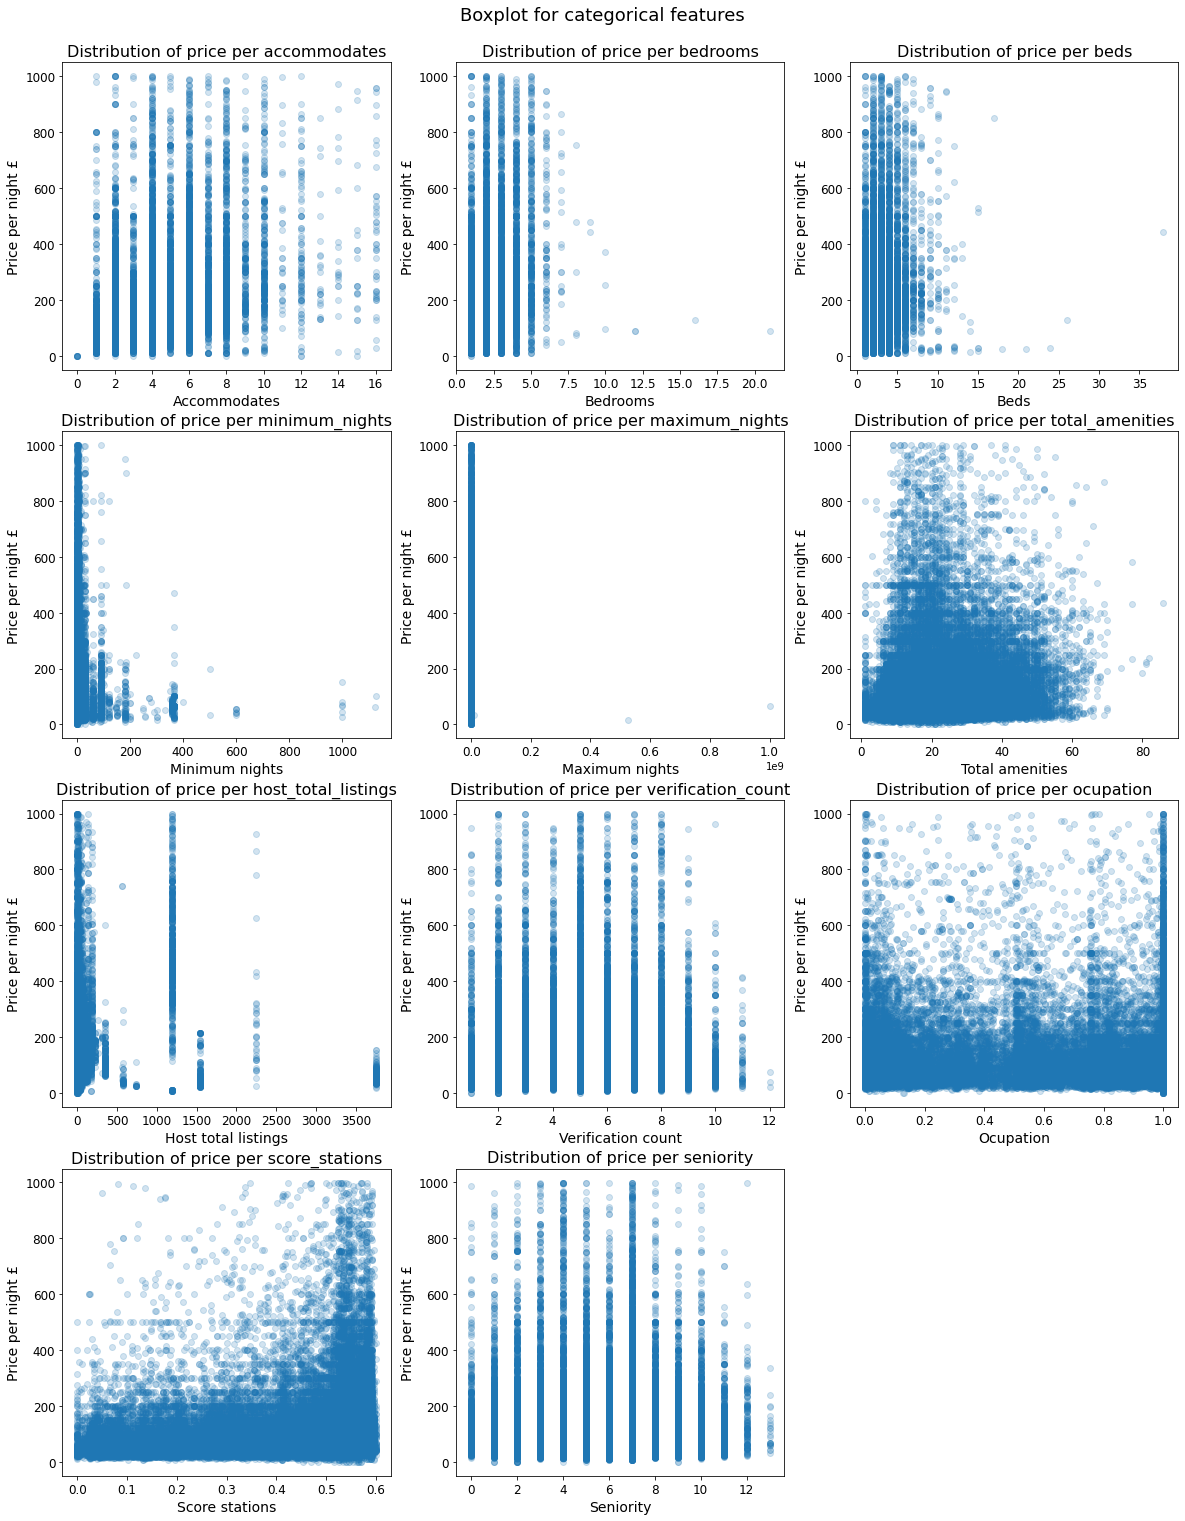

In [18]:
### Continue with numerical variables - scatterplots

COLS_SCATTER = NUM_COLS.copy()
COLS_SCATTER.remove('price_per_night')

# Plot scatterplots
fig, axs = plt.subplots(4, 3, figsize = (20, 26)) # Create figure and axes

for POS, FEATURE in enumerate(COLS_SCATTER):

    X_POS = POS // 3
    Y_POS = POS % 3
    
    # Separate data
    DF_PLOT = df_train_eda_num[[FEATURE, 'price_per_night']]
    
    axs[X_POS, Y_POS].scatter(x = DF_PLOT[FEATURE],
                             y = DF_PLOT['price_per_night'],
                             alpha = 0.2)
    
    # Format plot
    x_label = FEATURE.replace('_', ' ').capitalize()
    
    plot_params = {'subtitle': 'Distribution of price per ' + FEATURE,
                 'x_label': x_label,
                 'y_label': 'Price per night £'}

    plot_formatting(axs[X_POS, Y_POS], plot_params, has_legend = False)
        
axs[3, 2].remove()

plt.suptitle('Boxplot for categorical features',
             fontsize = CONFIG['title'],
             y = 0.91) # Main title of the plot
        
plt.show()

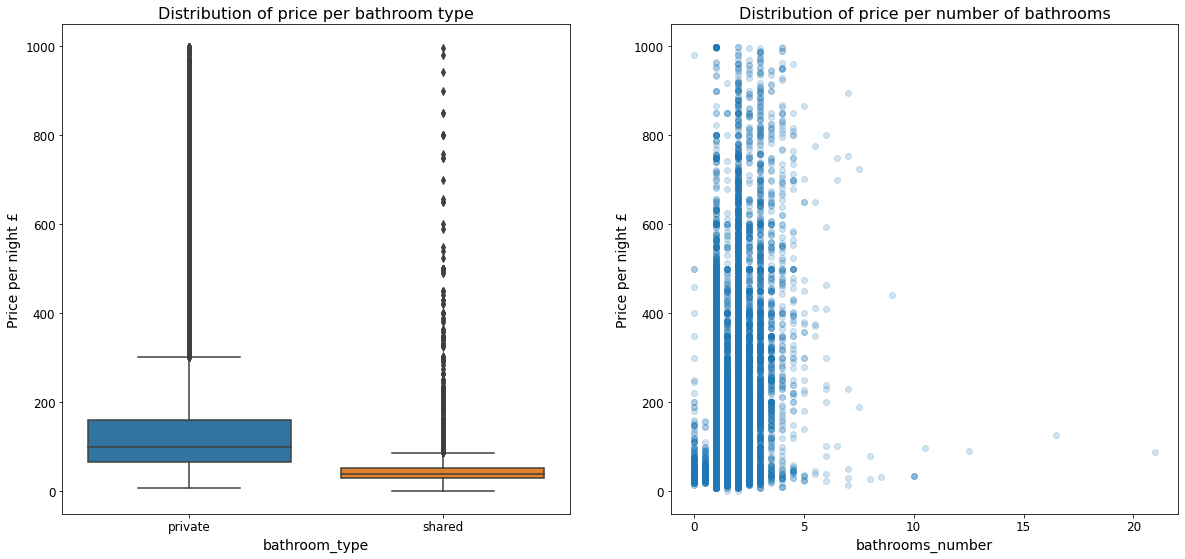

In [19]:
### Interpret bathrooms

df_train_eda_bathrooms = df_train[['bathrooms_text', 'price_per_night']]
df_train_eda_bathrooms.dropna(inplace = True)

# Infer number bathrooms
df_train_eda_bathrooms['bathrooms_number'] = df_train_eda_bathrooms['bathrooms_text'].str.split(' ', expand = True)[0]
df_train_eda_bathrooms['bathrooms_number'] = pd.to_numeric(df_train_eda_bathrooms['bathrooms_number'], errors = 'coerce')

# Add half bathrooms in text
df_train_eda_bathrooms.loc[(df_train_eda_bathrooms['bathrooms_text'].str.contains('half')) & (df_train_eda_bathrooms['bathrooms_number'].isnull()),
                          'bathrooms_number'] = 0.5

# Extract private or shared. Default is private
df_train_eda_bathrooms['bathroom_type'] = 'private'
df_train_eda_bathrooms.loc[df_train_eda_bathrooms['bathrooms_text'].str.contains('shar', na = False),
                          'bathroom_type'] = 'shared'

df_train_eda_bathrooms.head(20)

# Plot results
fig, axs = plt.subplots(1, 2, figsize = (20, 9)) # Create figure and axes

# Plot type
DF_PLOT_TYPE = df_train_eda_bathrooms[['bathroom_type', 'price_per_night']]

sns.boxplot(data = DF_PLOT_TYPE,
            x = 'bathroom_type',
            y = 'price_per_night',
            ax = axs[0])

# Format plot
plot_params = {'subtitle': 'Distribution of price per bathroom type',
             'x_label': 'bathroom_type',
             'y_label': 'Price per night £'}

plot_formatting(axs[0], plot_params, has_legend = False)

# Plot number of bathrooms
DF_PLOT_TYPE = df_train_eda_bathrooms[['bathrooms_number', 'price_per_night']]

axs[1].scatter(x = DF_PLOT_TYPE['bathrooms_number'],
               y = DF_PLOT_TYPE['price_per_night'],
               alpha = 0.2)

# Format plot
plot_params = {'subtitle': 'Distribution of price per number of bathrooms',
             'x_label': 'bathrooms_number',
             'y_label': 'Price per night £'}

plot_formatting(axs[1], plot_params, has_legend = False)


plt.show()

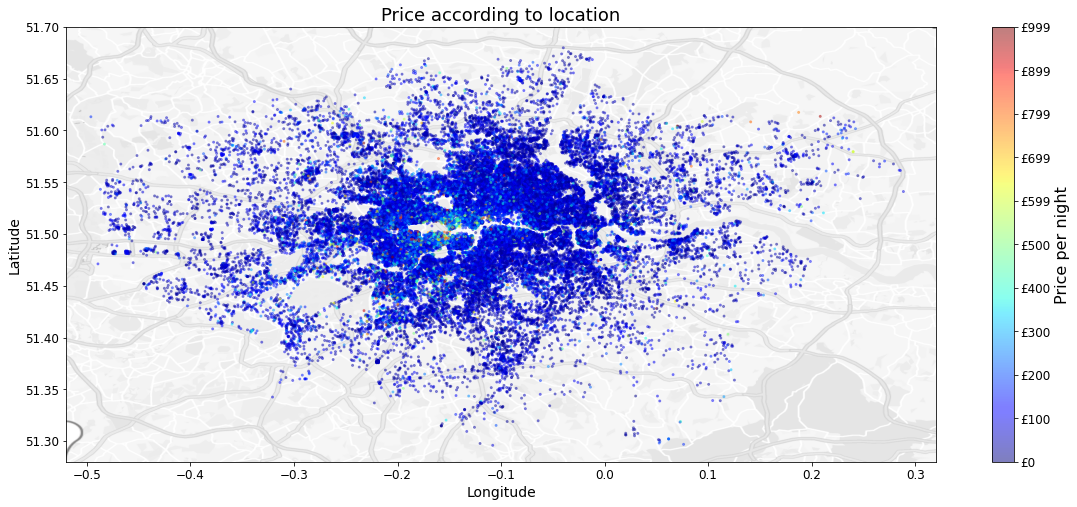

In [20]:
### Lat and long map
# Image credit: https://www.scribblemaps.com/create#/id=3srLGsIKlg&lat=51.51706263&lng=-0.0995404&z=10&t=custom_style
# Idea credit: hands-on-machine-learning by Aurelie Geron

df_train_eda_map = df_train[['latitude', 'longitude', 'price_per_night']]

df_train_eda_map.head()

london_img = mpimg.imread('./images/London map.png')

# Plot map
fig = plt.figure(1, (20, 8))
ax = fig.add_subplot(1, 1, 1)

df_train_eda_map.plot(kind = 'scatter',
                        x = 'longitude',
                        y = 'latitude',
                        s = 4,
                        c = 'price_per_night',
                        cmap = plt.get_cmap('jet'),
                        colorbar = False,
                        alpha = 0.4,
                        ax = ax)

plt.imshow(london_img, extent = [-0.52, 0.32, 51.28, 51.70], alpha = 0.5,
           cmap = plt.get_cmap('jet'))

# Add color bar
prices = df_train_eda_map['price_per_night']
tick_values = np.linspace(prices.min(), prices.max(), 11)

cbar = plt.colorbar(ticks = tick_values/prices.max())
cbar.ax.set_yticklabels(['£%d' % (round(v)) for v in tick_values],
                        fontsize = CONFIG['tick'])
cbar.set_label('Price per night', fontsize = CONFIG['subtitle'])

# Format plot
plot_params = {'title': 'Price according to location',
             'x_label': 'Longitude',
             'y_label': 'Latitude'}

plot_formatting(ax, plot_params, has_legend = False)

plt.show()

In [21]:
### Null distribution and outliers

df_train_null = df_train.copy()
df_train_null['nulls'] = df_train_null.isnull().sum(axis = 1)
df_train_null.sort_values(by = 'nulls', ascending = False).head()

df_train_null_rows = pd.DataFrame(df_train_null['nulls'].value_counts(sort = False, normalize = True))
df_train_null_rows['cumulative_sum'] = df_train_null_rows['nulls'].cumsum()
print(df_train_null_rows)
print('\n99.6% of rows contain at most 3 null. Rows with more than 3 null values are droped.\n')

df_train_null = df_train_null[df_train_null['nulls'] <= 3]
df_train_null.drop(columns = 'nulls', inplace = True)

# Outliers in max nights
MAX_NIGHTS_PCT = df_train_null['maximum_nights'].quantile(0.995)

df_train_null = df_train_null[df_train_null['maximum_nights'] <= MAX_NIGHTS_PCT]

print('Initial rows:', df_train.shape[0])
print('Final rows:', df_train_null.shape[0])

DROPED_ROWS = df_train.shape[0] - df_train_null.shape[0]
PERCENTAGE_DROPED_ROWS = DROPED_ROWS / df_train.shape[0]

print('{} droped rows, {:.2%} of initial count'.format(DROPED_ROWS, PERCENTAGE_DROPED_ROWS))

       nulls  cumulative_sum
1   0.531951        0.531951
0   0.416111        0.948062
2   0.045784        0.993846
3   0.002953        0.996799
11  0.000686        0.997485
5   0.001772        0.999257
4   0.000343        0.999600
6   0.000114        0.999714
13  0.000019        0.999733
7   0.000152        0.999886
12  0.000076        0.999962
14  0.000038        1.000000

99.6% of rows contain at most 3 null. Rows with more than 3 null values are droped.

Initial rows: 52486
Final rows: 52306
180 droped rows, 0.34% of initial count


## Data pre-processing

In [22]:
### Understand null distribution

X_COLS_DROP = ['listing_id', 'host_id', 'neighbourhood_id', 'latitude', 'longitude', 'property_type',
              'price_per_night', 'host_since', 'neighbourhood', 'date_reference', 'response_time']

ZONE_TRANSFORMATION = {'E': 'E',
                    'SW': 'SW',
                    'W': 'W',
                    'NW': 'NW',
                    'SE': 'SE',
                    'N': 'N',
                    'TW': 'SW',
                    'CR': 'SW',
                    'RM': 'E',
                    'IG': 'E',
                    'UB': 'NW',
                    'BR': 'SE',
                    'KT': 'SW',
                    'HA': 'NW',
                    'EC': 'E',
                    'SM': 'SW',
                    'DA': 'SE'}

df_train_y = df_train_null['price_per_night']
df_train_X = df_train_null.drop(X_COLS_DROP, axis = 1)
        
df_train_X = parse_bathrooms(df_train_X)

# Define lists of variables to apply to pipelines
NUM_NOLOG_VARIABLES = ['accommodates',
                       'bedrooms',
                       'beds',
                       'has_wifi',
                       'has_kitchen',
                       'has_heating',
                       'instant_bookable',
                       'host_is_in_london',
                       'is_superhost',
                       'host_has_profile_pic',
                       'identity_verified',
                       'verification_count',
                       'verification_phone',
                       'verification_email',
                       'verification_gov_id',
                       'ocupation',
                       'score_stations',
                       'seniority',
                       'bathroom_number']

NUM_LOG_VARIABLES = ['minimum_nights',
                     'maximum_nights',
                     'total_amenities',
                     'host_total_listings']

CAT_VARIABLES = ['room_type',
                 'bathroom_type']

CAT_ZONE = ['zone']

# Numeric variables - no log tranformation
pipeline_numNoLog = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

# Numeric variables - log transformation
pipeline_numLog = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('add1', FunctionTransformer(lambda x: x + 0.1)),
    ('log_transform', FunctionTransformer(np.log)),
    ('scaler', StandardScaler())
])
    
# Categorical variables
pipeline_cat = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent', missing_values = None)),
    ('encoder', OneHotEncoder(drop = 'first', sparse = False)),
    ('scaler', StandardScaler())
])

# Categorical variables - zone
pipeline_zone = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent', missing_values = None)),
    ('grouping_zone', FunctionTransformer(lambda x: np.vectorize(ZONE_TRANSFORMATION.get)(x))),
    ('encoder', OneHotEncoder(drop = 'first', sparse = False)),
    ('scaler', StandardScaler())
])

# Build general pipeline and process data
pipeline = ColumnTransformer([
    ('num_noLog', pipeline_numNoLog, NUM_NOLOG_VARIABLES),
    ('num_log', pipeline_numLog, NUM_LOG_VARIABLES),
    ('cat_ungrouped', pipeline_cat, CAT_VARIABLES),
    ('cat_zone', pipeline_zone, CAT_ZONE)
])

X_train = pipeline.fit_transform(df_train_X)

# Retrieve names
COLS_X_train = []

NUM_LIST_NOLOG = retrieve_pipeline_names_numeric(pipeline.transformers_[0])
NUM_LIST_LOG = retrieve_pipeline_names_numeric(pipeline.transformers_[1])
CAT_LIST = retrieve_pipeline_names_categorical(pipeline.transformers_[2], 1)
ZONE_LIST = retrieve_pipeline_names_categorical(pipeline.transformers_[3], 2)

COLS_X_train.extend(NUM_LIST_NOLOG)
COLS_X_train.extend(NUM_LIST_LOG)
COLS_X_train.extend(CAT_LIST)
COLS_X_train.extend(ZONE_LIST)

# Generate copy dataframe
X_train_df_copy = pd.DataFrame(X_train,
                               columns = COLS_X_train,
                               index = df_train_X.index)

# Target to list
y_train = df_train_y.tolist()

## Model training

In [23]:
### Train models

first_training = []

# Linear regression
first_training.append(cross_val_score(LinearRegression(),
                      X = X_train,
                      y = y_train,
                      cv = 5, # 5 fold cross validation
                      scoring = 'neg_root_mean_squared_error'))
print('Linear regression trained')

# Random forest regressor
first_training.append(cross_val_score(RandomForestRegressor(n_estimators = 100,
                                             max_depth = 10,
                                             random_state = RANDOM_SEED),
                      X = X_train,
                      y = y_train,
                      cv = 5, # 5 fold cross validation
                      scoring = 'neg_root_mean_squared_error'))
print('Random forest regression trained')

# Compute means of RMSE and plot
DF_MODELS = ['Linear regression', 'Random forest regression']
DF_RUNS = ['Initial train'] * len(DF_MODELS)
DF_ORDER = np.ones(len(DF_MODELS)) * 0
DF_RMSE = [np.mean(x) for x in first_training]

df_training_results = pd.DataFrame({'model': DF_MODELS,
                                    'iteration': DF_RUNS,
                                    'order': DF_ORDER,
                                    'rmse': [-i for i in DF_RMSE]})

Linear regression trained
Random forest regression trained


In [24]:
### Hyperparameter tuning

second_training = []
best_params = []
best_estimator = []

# Grid search for Logistic regression
param_grid_LR = [{'alpha': [400]}] # 400 [0.1, 1, 10, 100, 400, 800]

grid_search_LR = GridSearchCV(Ridge(),
                              param_grid_LR,
                              cv = 5,
                              scoring = 'neg_root_mean_squared_error',
                              return_train_score = True).fit(X_train, y_train)

second_training.append(grid_search_LR.best_score_)
best_params.append(grid_search_LR.best_params_)
best_estimator.append(grid_search_LR.best_estimator_)
print('Grid search done for Ridge regression')

# Grid search for Random Forest
param_grid_RF = [{'n_estimators': [450], #400 [100, 200, 500, 1000]
                 'max_depth': [50], #30  [20, 30, 40]
                 'min_samples_leaf': [1e-7]}] # 1e-6 [5e-5, 1e-4, 1e-3]

grid_search_RF = GridSearchCV(RandomForestRegressor(random_state = RANDOM_SEED),
                              param_grid_RF,
                              cv = 5,
                              scoring = 'neg_root_mean_squared_error',
                              return_train_score = True).fit(X_train, y_train)

second_training.append(grid_search_RF.best_score_)
best_params.append(grid_search_RF.best_params_)
best_estimator.append(grid_search_RF.best_estimator_)
print('Grid search done for random forest regressor')

# Consolidate results for iteration 2
DF_RUNS = ['Tuned parameters'] * len(DF_MODELS)
DF_ORDER = np.ones(len(DF_MODELS)) * 1
DF_RMSE = second_training

DF_TRAINING = pd.DataFrame({'model': DF_MODELS,
                            'iteration': DF_RUNS,
                            'order': DF_ORDER,
                            'rmse': [-i for i in DF_RMSE]})

df_training_results = df_training_results.append(DF_TRAINING)

Grid search done for Ridge regression
Grid search done for random forest regressor


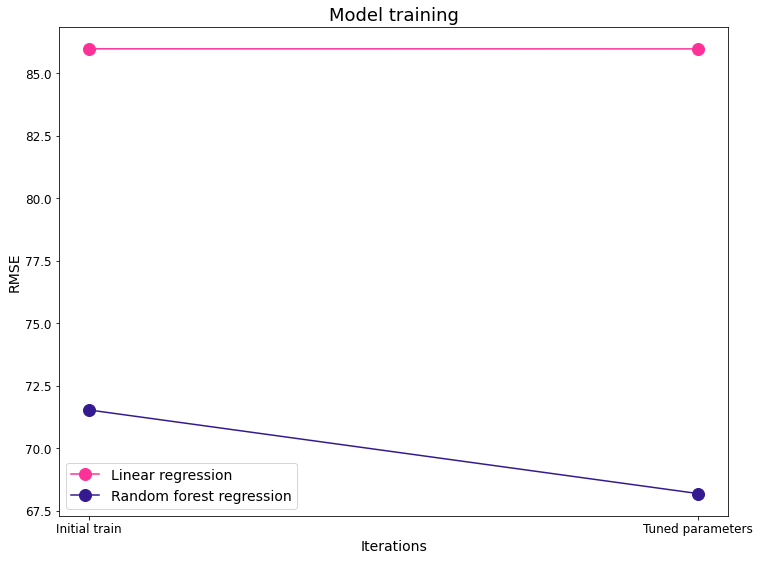

In [25]:
### Plot results for model training

model_colours = {'Linear regression': '#fe3199',
                'Random forest regression': '#351990'}

fig, ax = plt.subplots(figsize = (12, 9))

X_AXIS = df_training_results[['iteration', 'order']].drop_duplicates()
X_AXIS.sort_values(by = 'order', inplace = True)

for MODEL in df_training_results['model'].unique():
    DF_PLOT = df_training_results[df_training_results['model'] == MODEL]
    DF_PLOT.sort_values(by = 'order', inplace = True)
    
    ax.plot(X_AXIS['order'],
           DF_PLOT['rmse'],
           color = model_colours[MODEL],
           label = MODEL,
           marker = 'o',
           markersize = 12)

# Format plot
ax.set_xticks(X_AXIS['order'])
ax.set_xticklabels(X_AXIS['iteration'])

plot_params = {'title': 'Model training',
             'x_label': 'Iterations',
             'y_label': 'RMSE'}

plot_formatting(ax, plot_params, has_legend = True)
    
fig.show()

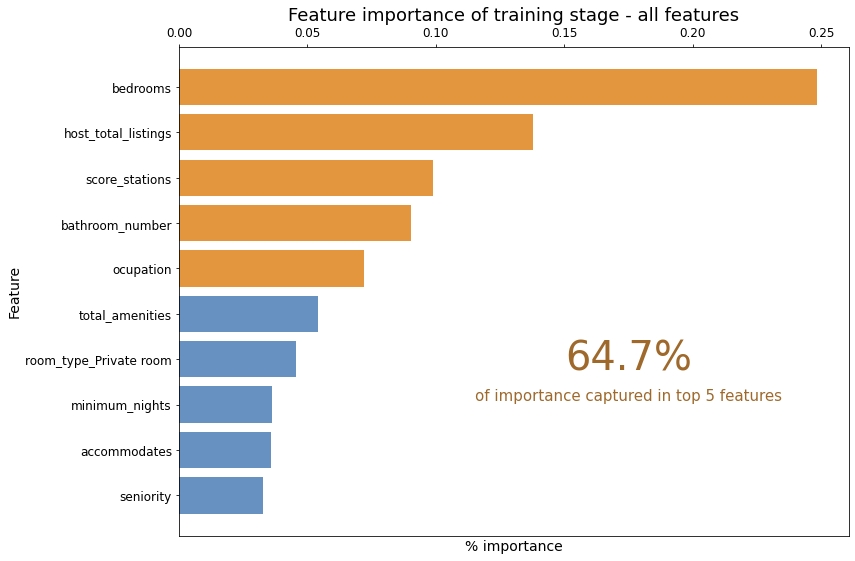

In [26]:
### Interpreting model results - feature importance

best_model = best_estimator[1]

dict_feature_importance_full = {'feature': COLS_X_train,
                              'importance': best_model.feature_importances_}

# Plot results
fig, ax = plt.subplots(figsize = (12, 9))

# Call plot function
ax = plot_feature_importance(ax, dict_feature_importance_full)

plot_params_full = {'title': 'Feature importance of training stage - all features',
                 'x_label': '% importance',
                 'y_label': 'Feature'}

plot_formatting(ax, plot_params_full, ignore_ticks = True)

plt.show()

In [27]:
### Pipeline for lighter model with only top 10 features

def pl_add(x):
    return x + 0.1;

def pl_add_inv(x):
    return x - 0.1;

# Define lists of variables to apply to pipelines
NUM_NOLOG_VARIABLES_LIGHT = ['accommodates',
                            'bedrooms',
                            'ocupation',
                            'score_stations',
                            'seniority',
                            'bathroom_number']

NUM_LOG_VARIABLES_LIGHT = ['minimum_nights',
                         'total_amenities',
                         'host_total_listings']

CAT_VARIABLES_LIGHT = ['room_type']

COLS_LIGHT = []
COLS_LIGHT.extend(NUM_NOLOG_VARIABLES_LIGHT)
COLS_LIGHT.extend(NUM_LOG_VARIABLES_LIGHT)
COLS_LIGHT.extend(CAT_VARIABLES_LIGHT)

# Numeric variables - no log tranformation
pipeline_numNoLog_light = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

# Numeric variables - log transformation
pipeline_numLog_light = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('add1', FunctionTransformer(pl_add, inverse_func = pl_add_inv)),
    ('log_transform', FunctionTransformer(np.log, inverse_func = np.exp)),
    ('scaler', StandardScaler())
])
    
# Categorical variables
pipeline_cat_light = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent', missing_values = None)),
    ('encoder', OneHotEncoder(drop = 'first', sparse = False)),
    ('scaler', StandardScaler())
])

# Build general pipeline and process data
pipeline_light = ColumnTransformer([
    ('num_noLog', pipeline_numNoLog_light, NUM_NOLOG_VARIABLES_LIGHT),
    ('num_log', pipeline_numLog_light, NUM_LOG_VARIABLES_LIGHT),
    ('cat_ungrouped', pipeline_cat_light, CAT_VARIABLES_LIGHT)
])

df_train_X_light = df_train_X[COLS_LIGHT]
X_train_light = pipeline_light.fit_transform(df_train_X_light)

# Retrieve names
COLS_X_train_light = []

NUM_LIST_NOLOG_light = retrieve_pipeline_names_numeric(pipeline_light.transformers_[0])
NUM_LIST_LOG_light = retrieve_pipeline_names_numeric(pipeline_light.transformers_[1])
CAT_LIST_light = retrieve_pipeline_names_categorical(pipeline_light.transformers_[2], 1)

COLS_X_train_light.extend(NUM_LIST_NOLOG_light)
COLS_X_train_light.extend(NUM_LIST_LOG_light)
COLS_X_train_light.extend(CAT_LIST_light)

# Generate copy dataframe
X_train_df_copy_light = pd.DataFrame(X_train_light,
                               columns = COLS_X_train_light,
                               index = df_train_X.index)
y_sr = pd.Series(y_train, name = 'target')

In [28]:
### Train light model

param_grid_RF_light = [{'n_estimators': [75], #400 [100, 200, 500, 1000]
                 'max_depth': [20], #30  [20, 30, 40]
                 'min_samples_leaf': [1e-4]}] # 1e-6 [5e-5, 1e-4, 1e-3]

grid_search_RF_light = GridSearchCV(RandomForestRegressor(random_state = RANDOM_SEED),
                              param_grid_RF_light,
                              cv = 5,
                              scoring = 'neg_root_mean_squared_error',
                              return_train_score = True).fit(X_train_light, y_train)

model_score_light = grid_search_RF_light.best_score_
model_light = grid_search_RF_light.best_estimator_

print('Light random forest trained')

Light random forest trained


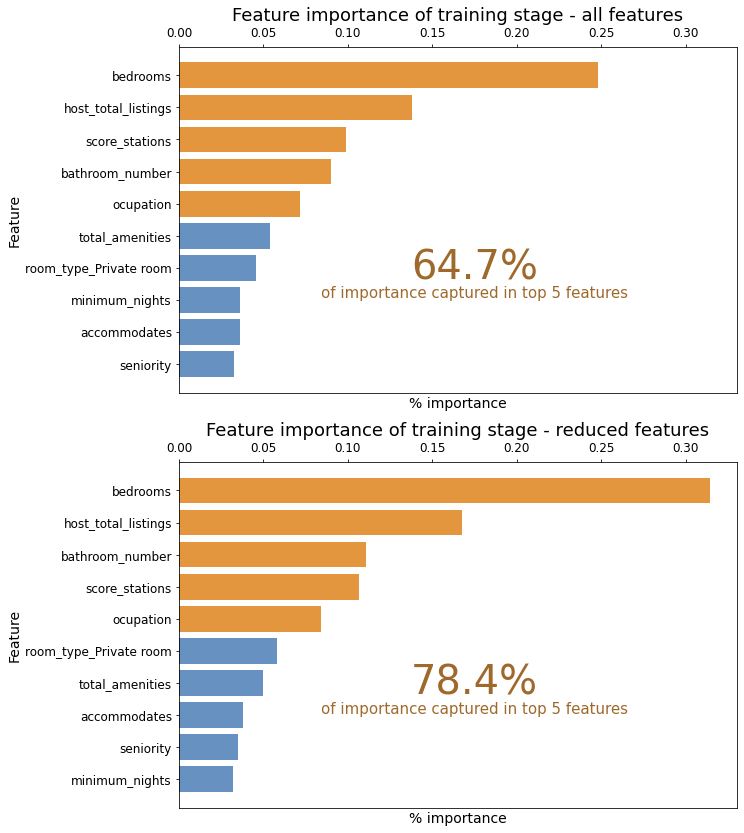

In [29]:
dict_feature_importance_light = {'feature': COLS_X_train_light,
                              'importance': model_light.feature_importances_}

fig, axs = plt.subplots(2, 1, figsize = (10, 14), sharex = True) # Create figure and axes
    
# Call plot function - full
axs[0] = plot_feature_importance(axs[0], dict_feature_importance_full)
plot_formatting(axs[0], plot_params_full, ignore_ticks = True)

# Call plot function - light
axs[1] = plot_feature_importance(axs[1], dict_feature_importance_light)

# Format plot - light
plot_params_light = {'title': 'Feature importance of training stage - reduced features',
                 'x_label': '% importance',
                 'y_label': 'Feature'}

plot_formatting(axs[1], plot_params_light, ignore_ticks = True)

plt.show()

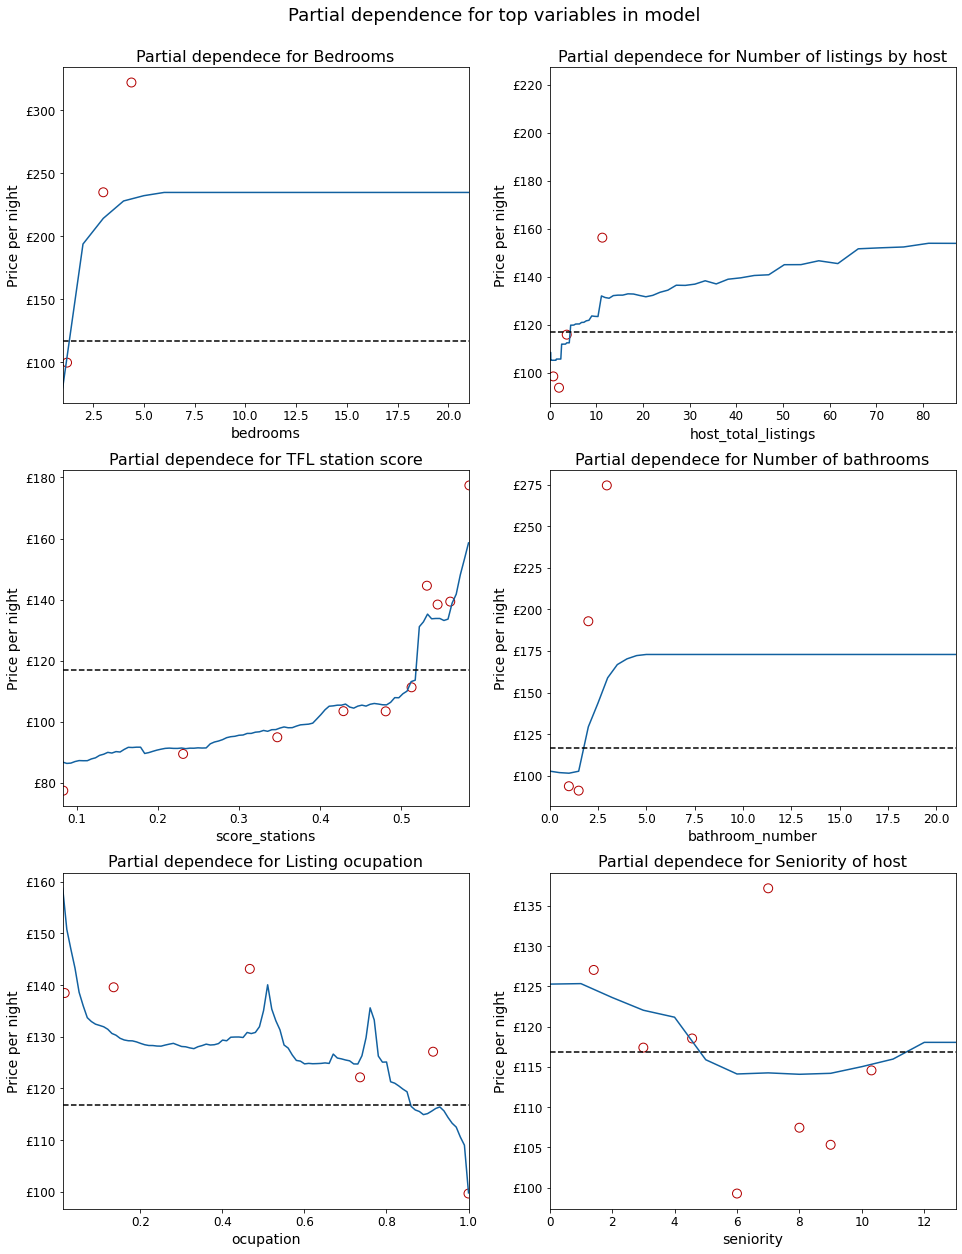

In [30]:
### Plot partial dependence
PARTIAL_DEPENDENCE_VARS = {'bedrooms': 'Bedrooms',
                        'host_total_listings': 'Number of listings by host',
                        'score_stations': 'TFL station score',
                        'bathroom_number': 'Number of bathrooms',
                        'ocupation': 'Listing ocupation',
                        'seniority': 'Seniority of host'}

fig, axs = plt.subplots(3, 2, figsize = (16, 21))

for POS, FEATURE in enumerate(PARTIAL_DEPENDENCE_VARS.keys()):

    X_POS = POS // 2
    Y_POS = POS % 2

    # Plot partial dependence
    axs[X_POS, Y_POS] = plot_partial_dependence(X_train_df_copy_light,
                                                y_sr,
                                                FEATURE,
                                                model_light,
                                                pipeline_light,
                                                axs[X_POS, Y_POS])
    
    # Format plot
    plot_params = {'subtitle': 'Partial dependece for ' + PARTIAL_DEPENDENCE_VARS[FEATURE],
                 'x_label': FEATURE,
                 'y_label': 'Price per night'}

    plot_formatting(axs[X_POS, Y_POS], plot_params)
    
plt.suptitle('Partial dependence for top variables in model',
             fontsize = CONFIG['title'],
             y = 0.92)
    
plt.show()

## Validation against test set

In [31]:
### Evaluate test set

df_test_null = df_test.dropna(subset = ['price_per_night'])

df_test_y = df_test_null['price_per_night']
df_test_X = df_test_null.drop(X_COLS_DROP, axis = 1)

# Transform data
df_test_X = parse_bathrooms(df_test_X)
df_test_X = df_test_X[COLS_LIGHT]
X_test = pipeline_light.transform(df_test_X)

# RMSE and R2 metrics
eval_metrics = {'r2': r2_score,
                'rmse': mean_squared_error}

data_partitions = {'training': [X_train_light, y_sr],
                    'test': [X_test, df_test_y]}

partitions = []
metric_names = []
metric_val = []

for metric_name in eval_metrics:
    for partition in data_partitions:
        
        partitions.append(partition)
        metric_names.append(metric_name)
        if(metric_name == 'rmse'):
            METRIC = eval_metrics[metric_name](data_partitions[partition][1],
                                               model_light.predict(data_partitions[partition][0]),
                                               squared = False)
        else:
            METRIC = eval_metrics[metric_name](data_partitions[partition][1],
                                               model_light.predict(data_partitions[partition][0]))
            
        metric_val.append(METRIC)
        
df_evaluation_results = pd.DataFrame({'partition': partitions,
                                     'metric': metric_names,
                                     'value': metric_val})

df_evaluation_results_pivot = pd.pivot_table(df_evaluation_results,
                                            index = 'partition',
                                            columns = 'metric',
                                            values = 'value',
                                            aggfunc = 'sum').reset_index()

print('Results for model evaluation:\n')
print(df_evaluation_results_pivot)

Results for model evaluation:

metric partition        r2       rmse
0           test  0.637013  70.365846
1       training  0.778730  55.967919


## Deploy models

In [32]:
### Adapt pipeline to indexed columns only (no name)

def pl_add(x):
    return x + 0.1;

def pl_add_inv(x):
    return x - 0.1;

# Define lists of variables to apply to pipelines
NUM_NOLOG_VARIABLES_LIGHT = ['accommodates',
                            'bedrooms',
                            'ocupation',
                            'score_stations',
                            'seniority',
                            'bathroom_number']

NUM_LOG_VARIABLES_LIGHT = ['minimum_nights',
                         'total_amenities',
                         'host_total_listings']

CAT_VARIABLES_LIGHT = ['room_type']

COLS_LIGHT = []
COLS_LIGHT.extend(NUM_NOLOG_VARIABLES_LIGHT)
COLS_LIGHT.extend(NUM_LOG_VARIABLES_LIGHT)
COLS_LIGHT.extend(CAT_VARIABLES_LIGHT)

# Numeric variables - no log tranformation
pipeline_numNoLog_light = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

# Numeric variables - log transformation
pipeline_numLog_light = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('add1', FunctionTransformer(pl_add, inverse_func = pl_add_inv)),
    ('log_transform', FunctionTransformer(np.log, inverse_func = np.exp)),
    ('scaler', StandardScaler())
])
    
# Categorical variables
pipeline_cat_light = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent', missing_values = None)),
    ('encoder', OneHotEncoder(drop = 'first', sparse = False)),
    ('scaler', StandardScaler())
])

# Change VARIABLES to COL_INDEX
NUM_NOLOG_VARIABLES_LIGHT_INDEX = [df_train_X_light.columns.get_loc(i) for i in NUM_NOLOG_VARIABLES_LIGHT]
NUM_LOG_VARIABLES_LIGHT_INDEX = [df_train_X_light.columns.get_loc(i) for i in NUM_LOG_VARIABLES_LIGHT]
CAT_VARIABLES_LIGHT_INDEX = [df_train_X_light.columns.get_loc(i) for i in CAT_VARIABLES_LIGHT]

# Build general pipeline and process data
pipeline_light = ColumnTransformer([
    ('num_noLog', pipeline_numNoLog_light, NUM_NOLOG_VARIABLES_LIGHT_INDEX),
    ('num_log', pipeline_numLog_light, NUM_LOG_VARIABLES_LIGHT_INDEX),
    ('cat_ungrouped', pipeline_cat_light, CAT_VARIABLES_LIGHT_INDEX)
])

pipeline_light.fit(df_train_X_light)

print('Successfully fitted pipeline')

Successfully fitted pipeline


In [33]:
### Export models locally

with open(MODEL_PATH + 'pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline_light, f)
    
with open(MODEL_PATH + 'predictive_model.pkl', 'wb') as f:
    pickle.dump(model_light, f)

In [34]:
### Save backup in AWS

s3_client = boto3.client("s3")
s3_model_bucket_name = os.environ.get('AWS_BUCKET_MODEL')

files = [f for f in os.listdir(MODEL_PATH) if os.path.isfile(os.path.join(MODEL_PATH, f))]
for f in files:
    s3_client.upload_file(MODEL_PATH + f, s3_model_bucket_name, f)